# Data Wrangling with Spark
This workspace contains a tiny subset (128MB) of the full dataset available (12GB) to explore a smaller subset with Spark before deploying your cluster on the cloud. The dataset describes log events comming from a music streaming service. The records describe events such as logging in to the site, visiting a page, listening to the next song, seeing an ad.

In [1]:
!pip install --upgrade matplotlib

    100% |████████████████████████████████| 11.5MB 3.1MB/s eta 0:00:01   47% |███████████████                 | 5.4MB 15.5MB/s eta 0:00:01    58% |██████████████████▉             | 6.8MB 12.9MB/s eta 0:00:01    85% |███████████████████████████▌    | 9.9MB 10.6MB/s eta 0:00:01
    100% |████████████████████████████████| 49.4MB 426kB/s eta 0:00:01   13% |████▏                           | 6.4MB 8.3MB/s eta 0:00:06    14% |████▋                           | 7.1MB 10.8MB/s eta 0:00:04    15% |█████                           | 7.7MB 13.7MB/s eta 0:00:04    16% |█████▍                          | 8.3MB 14.5MB/s eta 0:00:03    19% |██████                          | 9.4MB 27.2MB/s eta 0:00:02    20% |██████▌                         | 10.0MB 12.9MB/s eta 0:00:04    21% |███████                         | 10.6MB 12.6MB/s eta 0:00:04    24% |███████▉                        | 12.2MB 13.0MB/s eta 0:00:03    25% |████████▎                       | 12.7MB 14.8MB/s eta 0:00:03    26% |████████▋            

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.types import*

import datetime

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("Spark SQL").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# the IP address of the master node
path = "mini_sparkify_event_data.json"

In [5]:
# loading the json file into a spark DataFrame
user_log = spark.read.json(path)

## Data Exploration 

In [6]:
# Seeing the columns we have in this dataframe
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



There are fields describing the user like firstName, lastName and userId. We also have information about the request, for example, the page the user accessed, the HTTP method, and the status of the request.

In [7]:
# looking at one particular record
user_log.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

Here we can see that Colin was listening to "Rockpools"

In [8]:
# Looking at the first 5 records
user_log.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
# Summary statistics on the length column
user_log.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [10]:
print("We have {} rows on the dataset".format(user_log.count()))

We have 286500 rows on the dataset


In [11]:
# Looking at the page requests that we have
user_log.select("page").dropDuplicates().sort("page").show(25)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



Users can login and out, visit the homepage, or play a song.

In [12]:
user_log.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



We have two subscriptions levels, and we are going to define that a user chured when the changed from paid to free user

In [13]:
user_log.select("auth").dropDuplicates().sort("auth").show() 

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [14]:
# Looking at the events of userId 30
user_log.select(["userId", "firstName", "page", "song"]).filter(user_log.userId == "30").head(10)

[Row(userId='30', firstName='Colin', page='NextSong', song='Rockpools'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Time For Miracles'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Harder Better Faster Stronger'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Passengers (Old Album Version)'),
 Row(userId='30', firstName='Colin', page='Add to Playlist', song=None),
 Row(userId='30', firstName='Colin', page='NextSong', song='Fuck Kitty'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Jade'),
 Row(userId='30', firstName='Colin', page='NextSong', song='So-Called Friends'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Represent'),
 Row(userId='30', firstName='Colin', page='NextSong', song='Here I Am')]

As users use different pages of the application, their page request are logged

## Dropping Rows with Missing Values
Dropping missing values, making sure that we have the userId and SessionId for all the records

In [15]:
# Dropping missing values
user_log_valid = user_log.dropna(how="any", subset=["userId", "sessionId"])

In [16]:
# Making sure that we have the userId and SessionId for all the records
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



There are not None values but there are users with no userId

In [17]:
# Looking at logs of users with no userId
user_log.select(["userId", "firstName", "page", "song"]).filter(user_log.userId == "").head(10)

[Row(userId='', firstName=None, page='Home', song=None),
 Row(userId='', firstName=None, page='Help', song=None),
 Row(userId='', firstName=None, page='Home', song=None),
 Row(userId='', firstName=None, page='Login', song=None),
 Row(userId='', firstName=None, page='Home', song=None),
 Row(userId='', firstName=None, page='Login', song=None),
 Row(userId='', firstName=None, page='Login', song=None),
 Row(userId='', firstName=None, page='Login', song=None),
 Row(userId='', firstName=None, page='Home', song=None),
 Row(userId='', firstName=None, page='Login', song=None)]

In [18]:
# filter for users with blank user id
blank_pages = user_log.filter(user_log.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()

blank_pages.collect()

[Row(blank_pages='Home'),
 Row(blank_pages='About'),
 Row(blank_pages='Submit Registration'),
 Row(blank_pages='Login'),
 Row(blank_pages='Register'),
 Row(blank_pages='Help'),
 Row(blank_pages='Error')]

It seems that the user's with no id represent users who have not signed up yet or who are signed out and are about to log in.
It may also represents users who got an error while registrating or loging in.

In [19]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [20]:
user_log_valid.count()

278154

We lost 8346 records. 

In [21]:
print("We lost {} records".format(user_log.count() - user_log_valid.count()))

We lost 8346 records


In [22]:
female_users = user_log_valid.filter(user_log_valid.gender == 'F') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

male_users = user_log_valid.filter(user_log_valid.gender == 'M') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

In [23]:
print("We have {} female users and {} male users".format(female_users, male_users))

We have 104 female users and 121 male users


How many songs were played from the most played artist?

In [24]:
user_log_valid.filter(user_log_valid.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(1)

+-------------+-----------+
|       Artist|Artistcount|
+-------------+-----------+
|Kings Of Leon|       1841|
+-------------+-----------+
only showing top 1 row



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Users Cancel Their Accounts
We want to distinguish user's activity before and after they cancel their account.

In [25]:
user_log_valid.filter("page = 'Cancellation Confirmation'").count()

52

We want to create a Churn column which divides the users who have confirm a cancellation to use as the label of the model.

In [26]:
# Adding a new column called Churn to our dataframe
# The value here will be 1 if the user cancelled, and zero other wise
# # create churn user column

flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("Churn", flag_churn_event("page"))

In [27]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
user_log_valid = user_log_valid.withColumn('Churn_phase', Fsum('Churn').over(windowval))

In [38]:
user_log_valid.select(["userId", "firstname", "ts", "page", "Churn", "Churn_phase"]).filter(user_log_valid.userId == "18").sort("ts").collect()

[Row(userId='18', firstname='Adriel', ts=1538499917000, page='Home', Churn=0, Churn_phase=1),
 Row(userId='18', firstname='Adriel', ts=1538499933000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId='18', firstname='Adriel', ts=1538500208000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId='18', firstname='Adriel', ts=1538500476000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId='18', firstname='Adriel', ts=1538500654000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId='18', firstname='Adriel', ts=1538500842000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId='18', firstname='Adriel', ts=1538500856000, page='Settings', Churn=0, Churn_phase=1),
 Row(userId='18', firstname='Adriel', ts=1538501009000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId='18', firstname='Adriel', ts=1538501340000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId='18', firstname='Adriel', ts=1538501587000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId='18', firstn

In [35]:
user_log_valid.select('userId').where(user_log_valid.Churn == 1).count()

52

In [37]:
user_log_valid.select('userId').where(user_log_valid.Churn_phase == 1).dropDuplicates().count()

52

In [29]:
churn_ids = []
for u in userId:
    churn_ids.append(int(u['userId']))

In [46]:
churn_ids[:5]

[18, 32, 125, 105, 17]

In [31]:
f = lambda x: 1 if x in churn_ids else 0

In [36]:
f(300001)

1

In [48]:
flag_churn_users = udf(lambda userId: userId in churn_ids)
user_log_valid = user_log_valid.withColumn("Churn_user", flag_churn_users("userId"))

In [49]:
user_log_valid.filter(user_log_valid.userId == 18).collect()

[Row(artist=None, auth='Logged In', firstName='Adriel', gender='M', itemInSession=0, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Home', registration=1535623466000, sessionId=242, song=None, status=200, ts=1538499917000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18', Churn=0, Cancel_phase=1, Churn_user='false'),
 Row(artist='Mike And The Mechanics', auth='Logged In', firstName='Adriel', gender='M', itemInSession=1, lastName='Mendoza', length=275.12118, level='paid', location='Kansas City, MO-KS', method='PUT', page='NextSong', registration=1535623466000, sessionId=242, song='A Beggar On A Beach Of Gold', status=200, ts=1538499933000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18', Churn=0, Cancel_phase=1, Churn_user='false'),
 Row(artist='T

In [72]:
user_log_valid.groupBy('Cancel phase').count().show()

+----------+------+
|churn_user| count|
+----------+------+
|         1| 44864|
|         0|233290|
+----------+------+



In [98]:
user_log_valid.filter(user_log_valid.userId == 32).collect()

[Row(artist=None, auth='Cancelled', firstName='Diego', gender='M', itemInSession=56, lastName='Mckee', length=None, level='paid', location='Phoenix-Mesa-Scottsdale, AZ', method='GET', page='Cancellation Confirmation', registration=1537167593000, sessionId=540, song=None, status=200, ts=1539033046000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='32', downgraded=0, phase=0, Churn=1, churn_user=1, hour='21', day='8', weekday=2, month='10'),
 Row(artist=None, auth='Logged In', firstName='Diego', gender='M', itemInSession=55, lastName='Mckee', length=None, level='paid', location='Phoenix-Mesa-Scottsdale, AZ', method='PUT', page='Cancel', registration=1537167593000, sessionId=540, song=None, status=307, ts=1539033031000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId

In [73]:
user_log_valid.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgraded=0, phase=0, Churn=0, churn_user=0)

In [74]:
# +--------------------+
# |                page|
# +--------------------+
# |          Add Friend|
# |     Add to Playlist|
# |               Error|
# |                Help|
# |               Login|
# |              Logout|
# |            NextSong|
# |            Register|
# |         Roll Advert|
# |       Save Settings|
# |            Settings|
# |         Thumbs Down|
# |           Thumbs Up|
# +--------------------+

#  |-- artist: string (nullable = true)
#  |-- auth: string (nullable = true)
#  |-- firstName: string (nullable = true)
#  |-- gender: string (nullable = true)
#  |-- itemInSession: long (nullable = true)
#  |-- lastName: string (nullable = true)
#  |-- length: double (nullable = true)
#  |-- level: string (nullable = true)
#  |-- location: string (nullable = true)
#  |-- method: string (nullable = true)
#  |-- page: string (nullable = true)
#  |-- registration: long (nullable = true)
#  |-- sessionId: long (nullable = true)
#  |-- song: string (nullable = true)
#  |-- status: long (nullable = true)
#  |-- ts: long (nullable = true)
#  |-- userAgent: string (nullable = true)
#  |-- userId: string (nullable = true)

# perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. 
# You can start by exploring aggregates on these two groups of users, observing how much of a specific action 
# they experienced per a certain time unit or number of songs played.

In [75]:
## Plot in a histogram the distinct artist that are listened by churn users and not churn users
# Plot distribution of gender in churn and not churn users
# Count the number of logouts in churn and not churn users
# thumbs up/ down ratio
## Avg of each page visited

# Help requested per day
# Login per day
## Error per day
# Thumbs up per day
## thumbs down per day

# Songs per hour and songs per day

# Check itemInSession 

## Calculating Statistics by Hour
How many songs do users listen to in a given hour?

In [76]:
# Converting timestamps to datetime from epoch time, to get the hour of the day
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
# Adding a new column called hour to our dataframe
user_log_valid = user_log_valid.withColumn("hour", get_hour(user_log_valid.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
user_log_valid = user_log_valid.withColumn("day", get_day(user_log_valid.ts))

get_weekday = udf(lambda ts: datetime.datetime.fromtimestamp(ts/1000), TimestampType())
user_log_valid = user_log_valid.withColumn("weekday", dayofweek(get_weekday(user_log_valid.ts)))

get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
user_log_valid = user_log_valid.withColumn("month", get_month(user_log_valid.ts))

In [77]:
user_log_valid.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgraded=0, phase=0, Churn=0, churn_user=0, hour='18', day='21', weekday=4, month='11')

Colin was listening to Martha Tilston at 12am

In [78]:
## Plot in a histogram the distinct artist that are listened by churn users and not churn users
artist_per_user = user_log_valid.filter(user_log_valid.churn_user == 0).groupby(user_log_valid.userId, user_log_valid.artist).count()
artist_per_user_pd = artist_per_user.toPandas()
artist_per_user_pd = artist_per_user_pd[~artist_per_user_pd['artist'].isnull()]
artist_per_user_pd = artist_per_user_pd.groupby('userId').count().drop("count", axis=1)

In [79]:
## Plot in a histogram the distinct artist that are listened by churn users and not churn users
artist_per_user_churn = user_log_valid.filter(user_log_valid.churn_user == 1).groupby(user_log_valid.userId, user_log_valid.artist).count()
artist_per_user_churn_pd = artist_per_user_churn.toPandas()
artist_per_user_churn_pd = artist_per_user_churn_pd[~artist_per_user_churn_pd['artist'].isnull()]
artist_per_user_churn_pd = artist_per_user_churn_pd.groupby('userId').count().drop("count", axis=1)

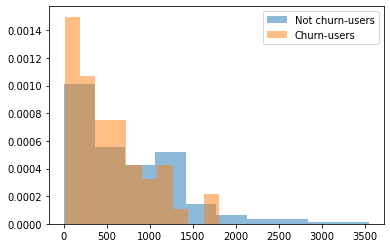

In [80]:
plt.hist(artist_per_user_pd["artist"], density=True, label="Not churn-users", alpha=0.5);
plt.hist(artist_per_user_churn_pd["artist"], density=True, label="Churn-users", alpha=0.5);
plt.legend();

We can notice from this graph that Not churn-users tend to listen to a higher number of artists compared to churn-users

In [81]:
# Avg of each page visited
df = user_log_valid.filter(user_log_valid.churn_user == 0).groupBy('page').count().withColumn('percent', col('count')/sum('count').over(Window.partitionBy()))
df.orderBy('percent', ascending=False).show()

+----------------+------+--------------------+
|            page| count|             percent|
+----------------+------+--------------------+
|        NextSong|191714|  0.8217840456084702|
|       Thumbs Up| 10692| 0.04583136868275537|
|            Home|  8410| 0.03604955205966823|
| Add to Playlist|  5488|0.023524368811350678|
|      Add Friend|  3641|0.015607184191349823|
|     Roll Advert|  2966|0.012713789703802134|
|          Logout|  2673|0.011457842170688843|
|     Thumbs Down|  2050|0.008787346221441126|
|       Downgrade|  1718|0.007364224784602855|
|        Settings|  1244| 0.00533241887779159|
|            Help|  1215|0.005208110077585837|
|           About|   439|0.001881778044493...|
|         Upgrade|   387|0.001658879506194...|
|   Save Settings|   252| 0.00108020060868447|
|           Error|   220|  9.4303227742295E-4|
|  Submit Upgrade|   127|5.443868146941575E-4|
|Submit Downgrade|    54| 2.31471559003815E-4|
+----------------+------+--------------------+



In [82]:
# Avg of each page visited
df = user_log_valid.filter(user_log_valid.churn_user == 1).groupBy('page').count().withColumn('percent', col('count')/sum('count').over(Window.partitionBy()))
df.orderBy('percent', ascending=False).show()

+--------------------+-----+--------------------+
|                page|count|             percent|
+--------------------+-----+--------------------+
|            NextSong|36394|  0.8112072039942939|
|           Thumbs Up| 1859| 0.04143634094151213|
|                Home| 1672|0.037268188302425106|
|     Add to Playlist| 1038|0.023136590584878745|
|         Roll Advert|  967|0.021554029957203995|
|          Add Friend|  636|0.014176176890156919|
|              Logout|  553| 0.01232614122681883|
|         Thumbs Down|  496|0.011055634807417974|
|           Downgrade|  337|0.007511590584878745|
|            Settings|  270|0.006018188302425107|
|                Help|  239|0.005327211126961484|
|             Upgrade|  112|0.002496433666191...|
|       Save Settings|   58|0.001292796005706134|
|               About|   56|0.001248216833095...|
|              Cancel|   52|0.001159058487874...|
|Cancellation Conf...|   52|0.001159058487874...|
|               Error|   32|7.132667617689016E-4|


In [83]:
# |Roll Advert|0.012713789703802134|
# |Roll Advert|0.021554029957203995|

# |Thumbs Down|0.008787346221441126|
# |Thumbs Down|0.011055634807417974|

# |Add Friend|0.015607184191349823|
# |Add Friend|0.014176176890156919|

# |Logout|0.011457842170688843|
# |Logout|0.01232614122681883|

# |Settings|0.00533241887779159|
# |Settings|0.006018188302425107|

In [ ]:
user_log_valid.filter((user_log_valid.userId == 140) & ((user_log_valid.phase == 0))).collect()

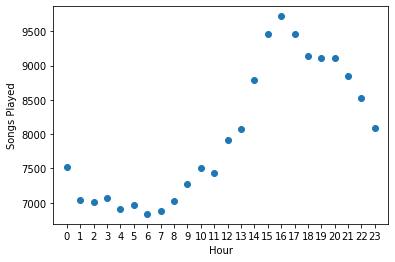

In [58]:
# Counting the next song page requests
songs_in_hour = user_log_valid.filter((user_log_valid.page == "NextSong") & (user_log_valid.churn_user == 0)).groupby(user_log_valid.hour).count().orderBy(user_log_valid.hour.cast("float"))
songs_in_hour_pd = songs_in_hour.toPandas()
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24)
# plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs Played");

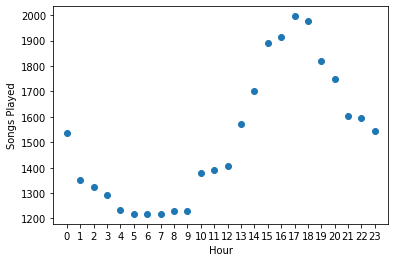

In [59]:
# Counting the next song page requests
songs_in_hour = user_log_valid.filter((user_log_valid.page == "NextSong") & (user_log_valid.churn_user == 1)).groupby(user_log_valid.hour).count().orderBy(user_log_valid.hour.cast("float"))
songs_in_hour_pd = songs_in_hour.toPandas()
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24)
# plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs Played");

We can see some trends in how many songs our users played in different hours of the day

In [ ]:
# # Counting the help page requests
# help_in_hour = user_log_valid.filter((user_log_valid.page == "Help") & (user_log_valid.churn_user == 0)).groupby(user_log_valid.hour).count().orderBy(user_log_valid.hour.cast("float"))
# help_in_hour_pd = help_in_hour.toPandas()
# plt.scatter(help_in_hour_pd["hour"], help_in_hour_pd["count"])
# plt.xlim(-1, 24)
# # plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
# plt.xlabel("Hour")
# plt.ylabel("Helps Requested");

In [ ]:
# # Counting the help page requests
# help_in_hour_chrun = user_log_valid.filter((user_log_valid.page == "Help") & (user_log_valid.churn_user == 1)).groupby(user_log_valid.hour).count().orderBy(user_log_valid.hour.cast("float"))
# help_in_hour_churn_pd = help_in_hour_chrun.toPandas()
# plt.scatter(help_in_hour_churn_pd["hour"], help_in_hour_churn_pd["count"])
# plt.xlim(-1, 24)
# # plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
# plt.xlabel("Hour")
# plt.ylabel("Helps Requested");

In [ ]:
# # Counting the regsitration page requests
# register_in_hour = user_log_valid.filter((user_log_valid.page == "Error") & (user_log_valid.churn_user == 0)).groupby(user_log_valid.hour).count().orderBy(user_log_valid.hour.cast("float"))
# register_in_hour_pd = register_in_hour.toPandas()
# register_in_hour_pd

In [ ]:
# login log out per day

In [ ]:
# Ratio of thumbs down over thumbs up
user_log_valid.filter((user_log_valid.churn_user == 0) & ((user_log_valid.page == 'Thumbs Up') | (user_log_valid.page == 'Thumbs Down'))).groupby("page").count().show()

In [ ]:
# Ratio of thumbs down over thumbs up
user_log_valid.filter((user_log_valid.churn_user == 1) & ((user_log_valid.page == 'Thumbs Up') | (user_log_valid.page == 'Thumbs Down'))).groupby("page").count().show()

In [ ]:
# avg count of each page visit from the total pages visited
user_log_valid.filter(user_log_valid.churn_user == 0).groupby("page").agg({'page':'count'}).show()

In [ ]:
# avg count of each page visit from the total pages visited
user_log_valid.filter(user_log_valid.churn_user == 1).groupby("page").agg({'page':'count'}).show()

In [ ]:
# Aggregates, number of songs

In [ ]:
# How many songs do notChurn users listen to on average between visiting our home page? 
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = user_log_valid.filter((user_log_valid.page == 'NextSong') | (user_log_valid.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .filter(user_log_valid.churn_user == 0) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

In [ ]:
# How many songs do Churn users listen to on average between visiting our home page? 
cusum.filter((cusum.page == 'NextSong')) \
    .filter(user_log_valid.churn_user == 1) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

In [ ]:
user_log_valid.head(1)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Users Downgrade Their Accounts
We want to distinguish user's activity before and after they downgraded their account from a paid one to a free one.

In [ ]:
user_log_valid.filter("page = 'Submit Downgrade'").count()

In [29]:
# Users who downgraded their service
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|     Kael|     M|           47|    Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|
|  null|Logged In|   Calvin|     M|           17| Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38|
|  null|Logged In|  

In [30]:
# Listing the activity of user 61 who downgraded their service
user_log_valid.select(["userId", "firstname", "page", "level", "song"]).filter(user_log_valid.userId == "61").collect()

[Row(userId='61', firstname='Parker', page='Home', level='free', song=None),
 Row(userId='61', firstname='Parker', page='NextSong', level='free', song='Point And Shoot (Explicit Album Version)'),
 Row(userId='61', firstname='Parker', page='NextSong', level='free', song='When A Man Loves A Woman'),
 Row(userId='61', firstname='Parker', page='NextSong', level='free', song='Ungod'),
 Row(userId='61', firstname='Parker', page='NextSong', level='free', song='Matricide'),
 Row(userId='61', firstname='Parker', page='NextSong', level='free', song='Simple'),
 Row(userId='61', firstname='Parker', page='Roll Advert', level='free', song=None),
 Row(userId='61', firstname='Parker', page='NextSong', level='free', song='Close (To The Edit)'),
 Row(userId='61', firstname='Parker', page='Thumbs Up', level='free', song=None),
 Row(userId='61', firstname='Parker', page='NextSong', level='free', song='The Warm Up'),
 Row(userId='61', firstname='Parker', page='NextSong', level='free', song='Vivir_ Amar_ So

After user 61 submited the downgrade she became a free user.

We want to create a phase column which divides the events of a particular user based on these special events. User inventory should have a different value in the phase column before and after she downgraded her service.

In [31]:
# Flaging log entries when users downgrade their accounts
# The value here will be 1 if the event refers to a downgrade, and zero other wise
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [32]:
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', downgraded=0)

The column downgraded appeared last

In [33]:
# Sorting records for a particular user in reverse time order, and adding up the values to distinguish each user's data 
# as either pre or post downgrade events
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
# Creating a phase column that uses the window function and cumulative sum
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [34]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).filter(user_log_valid.userId == "30").sort("ts").collect()

[Row(userId='30', firstname='Colin', ts=1538352117000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538352394000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538352676000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538352899000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538352905000, page='Add to Playlist', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538353084000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538353218000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538353441000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538353687000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538353909000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Coli

Looking at the records, all the events before the downgrade event belong to phase one and after they submit downgrade, we switched to phase zero. If we have more than one phase we will see the phase values decreasing from n to zero.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.